In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
from datetime import timedelta

Importing plotly failed. Interactive plots will not work.


In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style('white')
plt.rc('figure',figsize=(18,10))
plt.rc('font',size=16)

### __Part 1: Import Installation Data and convert it to time series__

In [3]:
installations = pd.read_csv('output.csv.gz')

/home/aydin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10,11,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#changing format of installation date from object to datetime
installations['installation_date'] = pd.to_datetime(installations['installation_date']).dt.strftime('%Y-%m-%d %H:%M:%S.%f')
installations['installation_date'] = pd.to_datetime(installations['installation_date'])
#set installation date as index
installations.sort_values('installation_date', inplace=True)
installations.set_index('installation_date', drop=False, inplace=True)
installations = installations[installations.system_size_DC != 424000 ] # erroneous systems size was removed

In [5]:
# start=(installations.index.date < pd.Timestamp(year=2016, month=12, day=31))
# end=(installations.index.date > pd.Timestamp(year=2016, month=12, day=1))
# check=installations[start & end]
# check.describe()

In [6]:
installations.head()

installation_date  system_size_DC  total_installed_price  \
installation_date                                                            
1998-01-30               1998-01-30          4.2515                    NaN   
1998-02-04               1998-02-04          8.3622                    NaN   
1998-02-28               1998-02-28             NaN                 9545.0   
1998-03-01               1998-03-01          0.6500                    NaN   
1998-04-01               1998-04-01        110.3000                    NaN   

                   rebate_or_grant customer_segment  expansion_system  \
installation_date                                                       
1998-01-30                     NaN              RES                 0   
1998-02-04                     NaN              RES                 0   
1998-02-28                     NaN              RES                 0   
1998-03-01                     NaN              RES                 0   
1998-04-01                     NaN          NON-RES                 0   

                   multiple_phase_system  new_construction  tracking  \
installation_date                                                      
1998-01-30                             0               NaN       NaN   
1998-02-04                             0               NaN       NaN   
1998-02-28                             0               NaN       NaN   
1998-03-01                             0               NaN       NaN   
1998-04-01                             0               NaN       NaN   

                   ground_mounted zip_code           city state  \
installation_date                                                 
1998-01-30                    NaN    95949    Nevada City    CA   
1998-02-04                    NaN    94518        Concord    CA   
1998-02-28                    NaN    97601  Klamath Falls    OR   
1998-03-01                    NaN    87109    ALBUQUERQUE    NM   
1998-04-01                    NaN    85281          Tempe    AZ   

                   self_installed technology_module_1 technology_module_2  \
installation_date                                                           
1998-01-30                    0.0                 NaN                 NaN   
1998-02-04                    0.0                 NaN                 NaN   
1998-02-28                    1.0                 NaN                 NaN   
1998-03-01                    NaN                 NaN                 NaN   
1998-04-01                    NaN                 NaN                 NaN   

                  technology_module_3  efficiency_module_1  \
installation_date                                            
1998-01-30                        NaN                  NaN   
1998-02-04                        NaN                  NaN   
1998-02-28                        NaN                  NaN   
1998-03-01                        NaN                  NaN   
1998-04-01                        NaN                  NaN   

                   efficiency_module_2  efficiency_module_3  
installation_date                                            
1998-01-30                         NaN                  NaN  
1998-02-04                         NaN                  NaN  
1998-02-28                         NaN                  NaN  
1998-03-01                         NaN                  NaN  
1998-04-01                         NaN                  NaN

In [7]:
monthly_output = installations[['system_size_DC']].resample('M').sum()
monthly_output[(monthly_output==monthly_output.max()).system_size_DC]

system_size_DC
installation_date                
2016-12-31           477671.93564

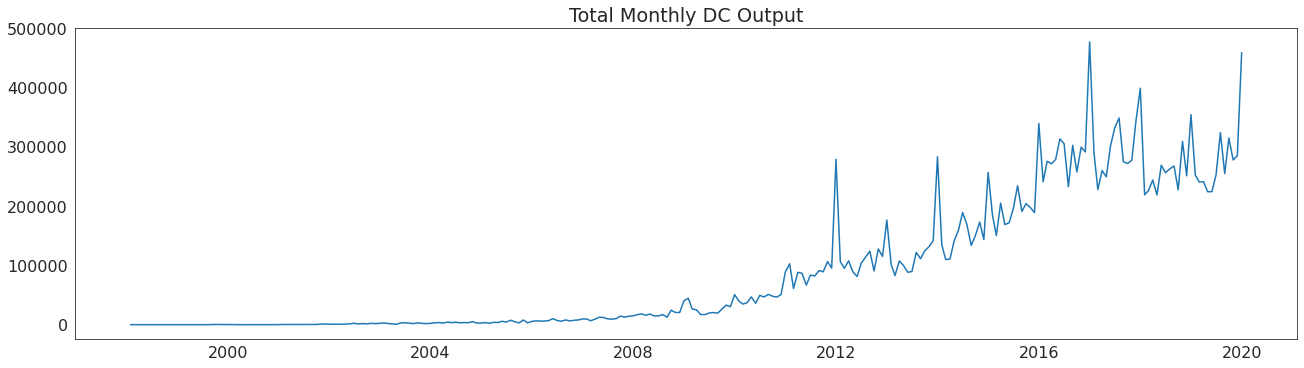

In [8]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(monthly_output.index.date, monthly_output)
plt.title('Total Monthly DC Output')
plt.show()

In [9]:
# installation counts and getting total monthly data
number_installs = pd.DataFrame(installations.index.value_counts()).rename(columns={'installation_date':'installation_numbers'})
number_installs['date'] = number_installs.index.date
number_installs['year'] = number_installs.index.year
number_installs.sort_values('date', inplace=True)
total_monthly=number_installs.resample('M').sum()
total_monthly.year=total_monthly.index.year

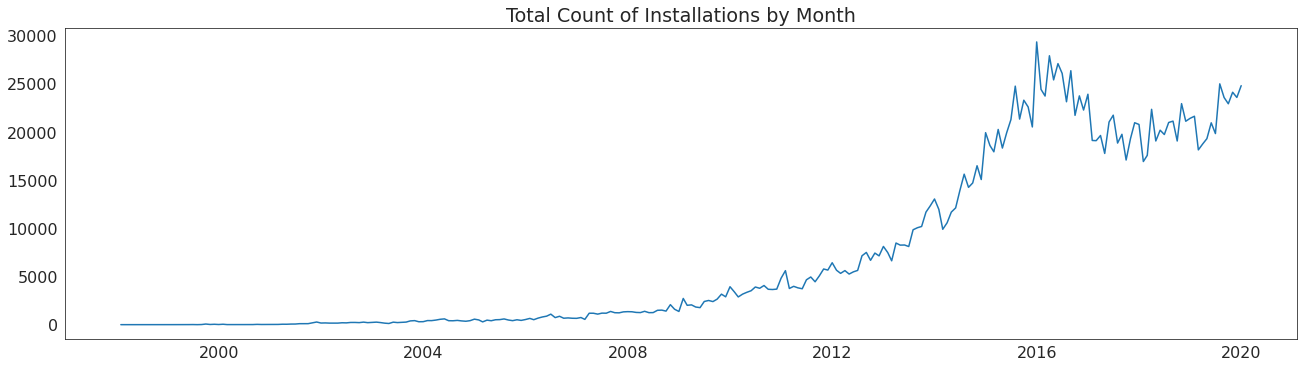

In [10]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(total_monthly.index.date,total_monthly['installation_numbers'])
plt.title('Total Count of Installations by Month')
plt.show()

### __Part 2: Get Sentiment Data__

In [11]:
titles = pd.read_csv("../title_date.csv", delimiter= '\t\t', names=['title','date'])
titles.head()

/home/aydin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


title              date
0  Volkswagen Has Created a R2D2-Like Charging Ro...  2021-01-08 18:30
1  Bullish on Solar Demand, TSEC Invests NT$700 M...  2021-01-07 18:30
2  TrendForce:Prices of Polysilicon Expected to R...  2021-01-07 10:56
3  Tesla Finalizes on Marching Towards the Indian...  2021-01-06 18:30
4  US Congress Gives Renewable Energy Industry a ...  2021-01-06 18:30

In [12]:
vader = SentimentIntensityAnalyzer()

In [13]:
def get_scores(titles):
    vader = SentimentIntensityAnalyzer()
    scores = titles['title'].apply(vader.polarity_scores).tolist() # Iterate through the headlines and get the polarity scores using vader
    scores_df = pd.DataFrame(scores) # Convert the 'scores' list of dicts into a DataFrame
    scored_news = titles.join(scores_df, rsuffix='_right') # Join the DataFrames of the news and the list of dicts
    scored_news['date'] = pd.to_datetime(titles.date).dt.date # Convert the date column from string to datetime
    return scored_news

In [14]:
scored_news=get_scores(titles)
scored_news['date'] = pd.to_datetime(scored_news['date'])
sentiment_series=scored_news.set_index('date', drop=False)[['compound', 'date']]

In [15]:
sentiment_series = sentiment_series.sort_index()

In [16]:
series_28_rolling_sum = sentiment_series.rolling('28d').sum()

In [17]:
series_28_monthly = sentiment_series.ewm(alpha = 0.01).mean().resample('M').mean()

In [18]:
sentiment_series.index

DatetimeIndex(['2010-04-02', '2010-05-10', '2010-05-10', '2010-05-11',
               '2010-05-17', '2010-05-17', '2010-05-18', '2010-05-18',
               '2010-05-20', '2010-05-20',
               ...
               '2021-01-04', '2021-01-05', '2021-01-05', '2021-01-05',
               '2021-01-06', '2021-01-06', '2021-01-06', '2021-01-07',
               '2021-01-07', '2021-01-08'],
              dtype='datetime64[ns]', name='date', length=9664, freq=None)

In [19]:
series_28_rolling_sum

compound
date                
2010-04-02    0.0000
2010-05-10    0.2732
2010-05-10    0.2732
2010-05-11    0.6617
2010-05-17    1.0636
...              ...
2021-01-06    6.9088
2021-01-06    6.9088
2021-01-07    6.5076
2021-01-07    6.3796
2021-01-08    6.6296

[9664 rows x 1 columns]

In [20]:
series_28_monthly

compound
date                
2010-04-30  0.000000
2010-05-31  0.178126
2010-06-30  0.141607
2010-07-31  0.168942
2010-08-31  0.212518
...              ...
2020-09-30  0.157342
2020-10-31  0.144973
2020-11-30  0.168158
2020-12-31  0.158906
2021-01-31  0.161313

[130 rows x 1 columns]

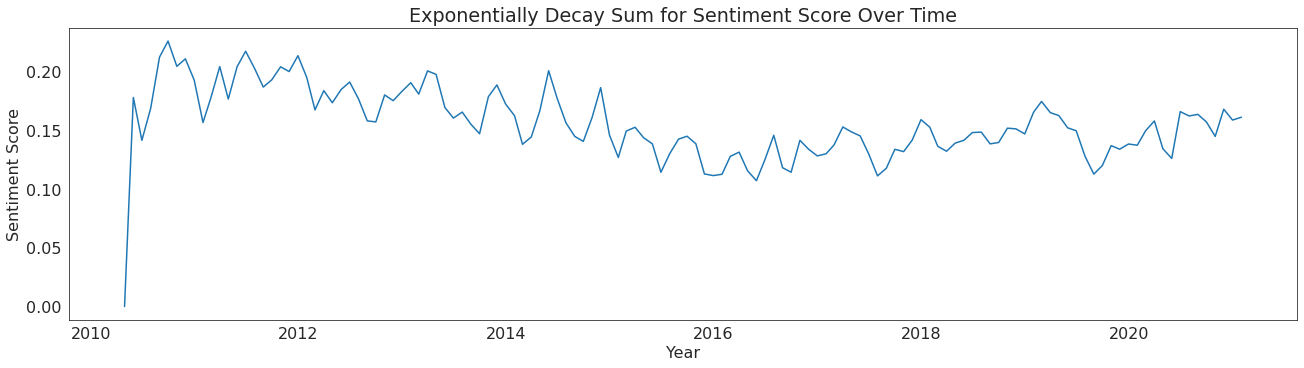

In [21]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(series_28_monthly.index.date, series_28_monthly)
plt.title('Exponentially Decay Sum for Sentiment Score Over Time')
ax.set_ylabel('Sentiment Score')
ax.set_xlabel('Year')
plt.show()
fig.savefig('../images/sentiment_plot.png')

In [22]:
#series_28_monthly=series_28_rolling_sum.resample('M').mean()

In [23]:
# fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
# ax.plot(series_28_monthly.index.date,series_28_monthly)
# plt.title('28 Days Sentiment Sum')
# plt.show()

### __Part 3: Get Silicone Price__

In [24]:
silicone_price=pd.read_csv('cleaned_prices.csv', na_values=['none'] )
silicone_price['date'] = pd.to_datetime(silicone_price['date'])
silicone_price=silicone_price.set_index('date', drop=False)
price_series=silicone_price.cost_parsed_USD
price_monthly=price_series.resample('M').mean() # get average monthly price

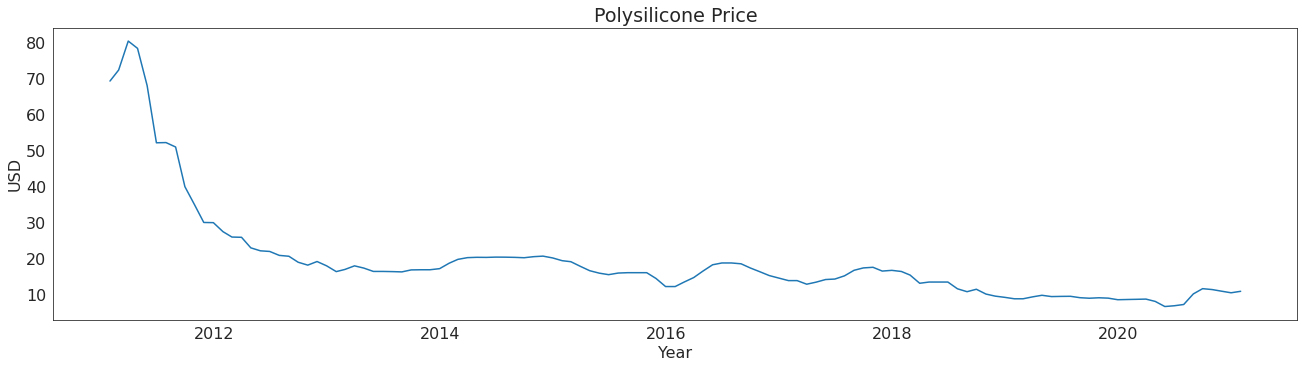

In [25]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(price_monthly.index.date, price_monthly)
plt.title('Polysilicone Price')
ax.set_ylabel('USD')
ax.set_xlabel('Year')
plt.show()
fig.savefig('../images/polysilicone.png')

### __Part 4: Get ETF Data__

In [26]:
icln = yf.download( tickers = "ICLN", period = "max", interval = "1d", auto_adjust = True )
icln = icln.resample('M').last().rename({"Close": "ICLN_Close"},axis=1).ICLN_Close
tan = yf.download(  tickers = "TAN", period = "max", interval = "1d", auto_adjust = True)
tan = tan.resample('M').last().rename({"Close": "TAN_Close"},axis=1).TAN_Close
qcln = yf.download(  tickers = "QCLN", period = "max", interval = "1d", auto_adjust = True)
qcln = qcln.resample('M').last().rename({"Close": "QCLN_Close"},axis=1).QCLN_Close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


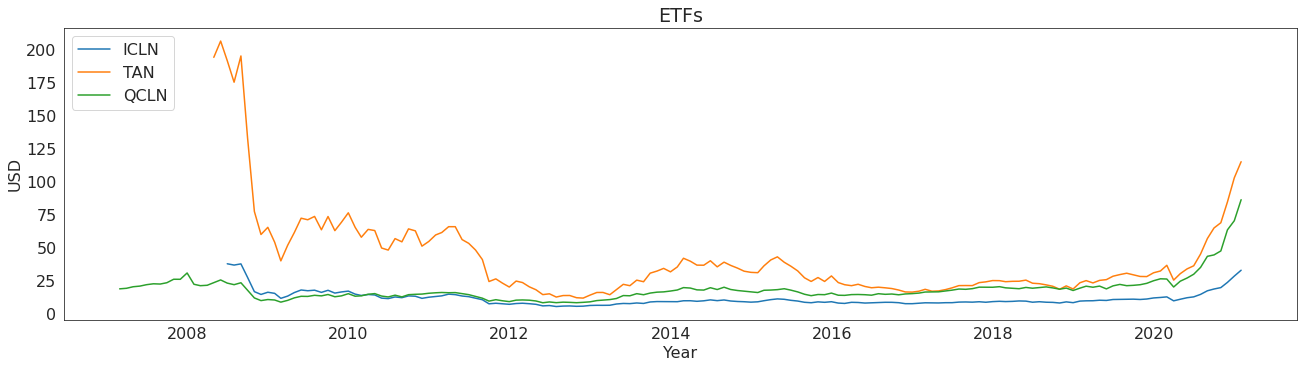

In [27]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(icln.index.date, icln, label = 'ICLN')
ax.plot(tan.index.date, tan, label = 'TAN')
ax.plot(qcln.index.date, qcln, label = 'QCLN')
ax.legend(loc='upper left' )
ax.set_ylabel('USD')
ax.set_xlabel('Year')
plt.title('ETFs')
plt.show()
fig.savefig('../images/ETFs.png')

In [28]:
icln_diff=icln.diff(1)
tan_diff=tan.diff(1)
qcln_diff=qcln.diff(1)
series_28_monthly_diff = series_28_monthly.diff(1)
price_monthly_diff = price_monthly.diff(1)

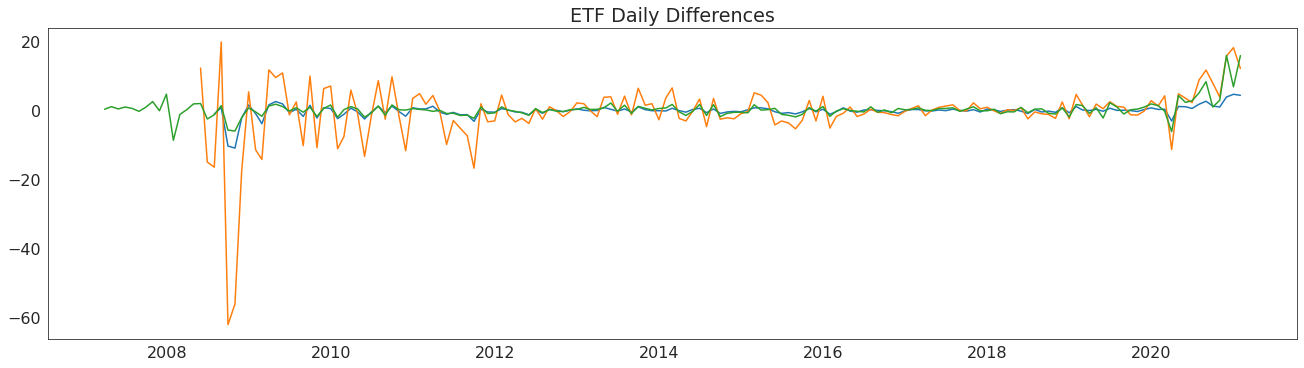

In [29]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(icln.index.date, icln_diff)
ax.plot(tan.index.date, tan_diff)
ax.plot(qcln.index.date, qcln_diff)
#ax.legend([icln, tan, qcln], ['icln', 'tan', 'qcln'])
plt.title('ETF Daily Differences')
plt.show()

### __Part 5: Plot all time series together__

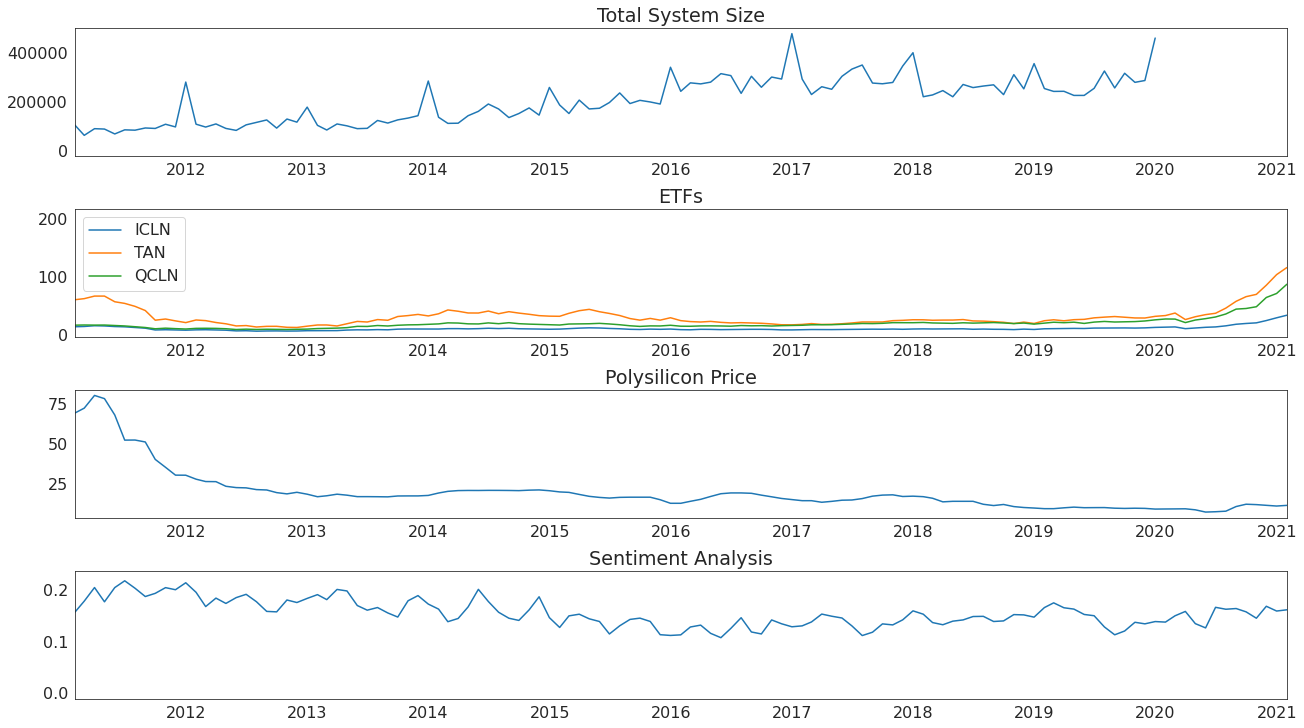

In [30]:
fig, ax = plt.subplots(4,1, figsize=(18,10), constrained_layout=True)
#ax[1].plot(total_monthly.index.date, total_monthly.installation_numbers)
ax[0].set_title('Total System Size')
ax[0].plot(monthly_output.index.date, monthly_output.system_size_DC)
ax[0].set_xlim(price_monthly.index.min(), price_monthly.index.max())
ax[1].set_title('ETFs')
ax[1].plot(icln.index.date, icln, label = 'ICLN')
ax[1].plot(tan.index.date, tan, label = 'TAN')
ax[1].plot(qcln.index.date, qcln, label = 'QCLN')
ax[1].legend()
ax[1].set_xlim(price_monthly.index.min(), price_monthly.index.max())
ax[2].plot(price_monthly.index.date, price_monthly)
ax[2].set_title('Polysilicon Price')
ax[2].set_xlim(price_monthly.index.min(), price_monthly.index.max())
ax[3].plot(series_28_monthly.index.date, series_28_monthly)
ax[3].set_title('Sentiment Analysis')
ax[3].set_xlim(price_monthly.index.min(), price_monthly.index.max())
#ax.legend([icln, tan, qcln], ['icln', 'tan', 'qcln'])
plt.xlim(price_monthly.index.min(), price_monthly.index.max())
plt.show()
fig.savefig('../images/six_time_series.png')

In [31]:
price_monthly.index.max()

Timestamp('2021-01-31 00:00:00', freq='M')

### __Part 6: Build Prophet Model__

Combine all 6 series in one dataframe.

In [32]:
combined_df = monthly_output.join([series_28_monthly_diff, price_monthly_diff ,icln_diff, qcln_diff, tan_diff], how='outer')

In [33]:
combined_df = combined_df[combined_df.cost_parsed_USD.notna()]

In [34]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-02-28 to 2021-01-31
Freq: M
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   system_size_DC   107 non-null    float64
 1   compound         120 non-null    float64
 2   cost_parsed_USD  120 non-null    float64
 3   ICLN_Close       120 non-null    float64
 4   QCLN_Close       120 non-null    float64
 5   TAN_Close        120 non-null    float64
dtypes: float64(6)
memory usage: 6.6 KB


In [35]:
combined_df['y']=combined_df.system_size_DC
combined_df['ds']=combined_df.index

In [36]:
combined_df

system_size_DC  compound  cost_parsed_USD  ICLN_Close  \
installation_date                                                          
2011-02-28           61131.212845  0.021283         3.066667    0.532914   
2011-03-31           88399.151944  0.026377         8.040000    1.289801   
2011-04-30           86866.328568 -0.027663        -2.024000   -0.370721   
2011-05-31           66837.401137  0.027596       -10.334750   -1.042655   
2011-06-30           83647.639915  0.013157       -15.897250   -0.493279   
...                           ...       ...              ...         ...   
2020-09-30                    NaN -0.006409         1.461200    1.347605   
2020-10-31                    NaN -0.012369        -0.248533    1.068100   
2020-11-30                    NaN  0.023185        -0.447417    3.962955   
2020-12-31                    NaN -0.009252        -0.448850    4.751766   
2021-01-31                    NaN  0.002407         0.414600    4.455000   

                   QCLN_Close  TAN_Close             y         ds  
installation_date                                                  
2011-02-28           0.222603   1.866962  61131.212845 2011-02-28  
2011-03-31          -0.185507   4.406025  88399.151944 2011-03-31  
2011-04-30           0.111315   0.000000  86866.328568 2011-04-30  
2011-05-31          -0.816257  -9.782867  66837.401137 2011-05-31  
2011-06-30          -0.742055  -2.837791  83647.639915 2011-06-30  
...                       ...        ...           ...        ...  
2020-09-30           1.058823   7.992336           NaN 2020-09-30  
2020-10-31           3.026966   3.976181           NaN 2020-10-31  
2020-11-30          15.993954  15.794853           NaN 2020-11-30  
2020-12-31           6.903530  18.261055           NaN 2020-12-31  
2021-01-31          15.949997  12.229996           NaN 2021-01-31  

[120 rows x 8 columns]

In [37]:
y_train = combined_df.loc[combined_df["ds"]<="2018-12-31"]
y_test  = combined_df.loc[(combined_df["ds"]>"2018-12-31") ]#& (combined_df["ds"]<"2019-12-31")]

In [38]:
model = Prophet(yearly_seasonality=True)
model.add_regressor('compound' )
model.add_regressor('cost_parsed_USD' )
model.add_regressor('ICLN_Close' )
model.add_regressor('QCLN_Close' )
model.add_regressor('TAN_Close' )

In [39]:
model.fit(y_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
forecast = model.predict(y_test.drop(columns="y"))

In [41]:
trained = model.predict(y_train.drop(columns="y"))

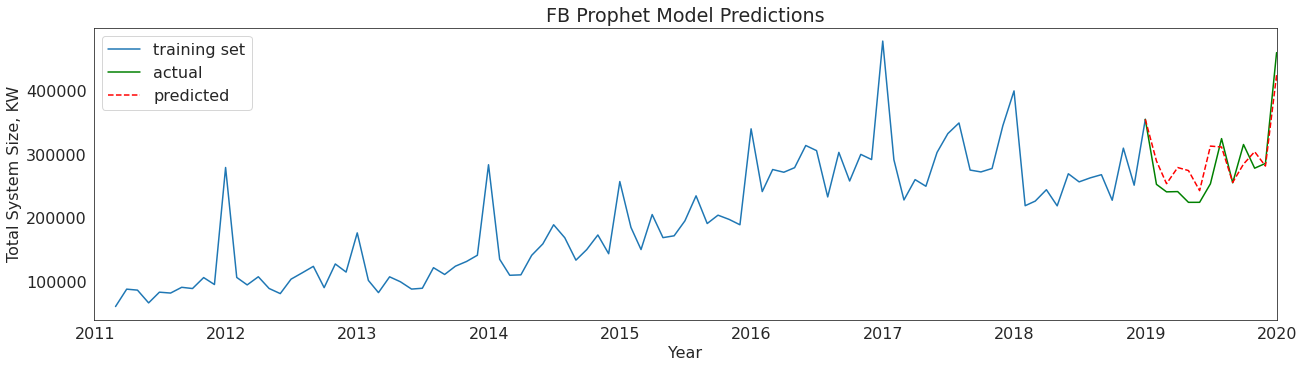

In [42]:
fig, ax = plt.subplots(1,1, figsize=(18,5), constrained_layout=True)
ax.plot(y_train.index.date, y_train.y, label = 'training set')

ax.plot(np.concatenate((y_train.index.values[-1], y_test.index.values),axis=None),
        np.concatenate((y_train.y[-1], y_test.y),axis=None), 
        color='g', label='actual')

ax.plot(np.concatenate((y_train.index.values[-1], forecast.ds),axis=None),
        np.concatenate((y_train.y[-1], forecast.yhat),axis=None), 
        linestyle='--', color='r', label='predicted')# ploting prediction data connected to training set

ax.set_xlim(combined_df.index.date.min()-timedelta(days=60), monthly_output.index.date.max()+ timedelta(days=1))

ax.set_ylabel("Total System Size, KW" )
ax.set_xlabel("Year")
ax.set_title('FB Prophet Model Predictions')
ax.legend(loc='upper left')
plt.show()
fig.savefig('../images/prophet_prediction.png')

In [43]:
# getting data from forecast before 2020 data
y_pred = forecast[forecast.ds<'2019-12-31']

In [44]:
# calculating rmse

In [45]:
rmse = mse(y_test[y_test.ds<'2019-12-31'].y, y_pred.yhat, squared=False)
mean_avg_error = mae(y_test[y_test.ds<'2019-12-31'].y, y_pred.yhat)
print(f'RMSE = {rmse:.02f}, MAE = {mean_avg_error:.02f}')

RMSE = 31729.38, MAE = 26303.32
